In [1]:
import tensorflow as tf
import numpy as np
import os
import tarfile
import requests
import re
from PIL import Image
import matplotlib.pyplot as plt

inception_pretrain_model_url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

In [2]:
inception_pretrain_model_dir='inception_model'

if not os.path.exists(inception_pretrain_model_dir):
    os.makedirs(inception_pretrain_model_dir)

filename=inception_pretrain_model_url.split('/')[-1]
filepath=os.path.join(inception_pretrain_model_dir,filename)

if not os.path.exists(filepath):
    print("download:",filename)
    r=requests.get(inception_pretrain_model_url, stream=True)
    with open(filepath, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
print("finish:", filename)

tarfile.open(filepath, 'r:gz').extractall(inception_pretrain_model_dir)

log_dir='inception_log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

download: inception-2015-12-05.tgz
finish: inception-2015-12-05.tgz


In [ ]:
inception_graph_def_file = os.path.join(inception_pretrain_model_dir, 'classify_image_graph_def.pb')
with tf.Session() as sess:
    #创建一个图来存放google训练好的模型
    with tf.gfile.FastGFile(inception_graph_def_file, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
    #保存图的结构
    writer = tf.summary.FileWriter(log_dir, sess.graph)
    writer.close()

images/9b4ef20973984c286da522d645c75e8.jpg


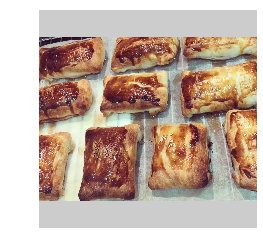

tray (score = 0.30748)
bakery, bakeshop, bakehouse (score = 0.09346)
French loaf (score = 0.07138)
potpie (score = 0.06892)
pretzel (score = 0.02049)

images/d184adce3ccaa9d574ab9ccd9ba176c.jpg


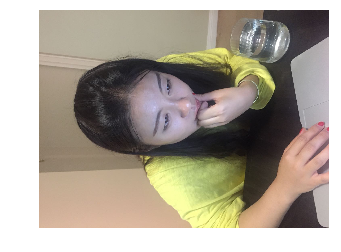

water jug (score = 0.20559)
hand blower, blow dryer, blow drier, hair dryer, hair drier (score = 0.16356)
hair spray (score = 0.10633)
paper towel (score = 0.04087)
water bottle (score = 0.03206)

images/f0264c61b9f82a6faf1556c816db32d.jpg


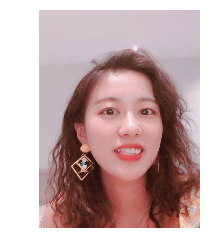

lipstick, lip rouge (score = 0.09405)
safety pin (score = 0.05529)
hair slide (score = 0.04601)
wig (score = 0.03706)
bikini, two-piece (score = 0.03257)



In [12]:

class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        
    def load(self,label_lookup_path,uid_lookup_path):
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        for line in proto_as_ascii_lines:
            #去掉换行符
            line = line.strip('\n')
            parsed_items = line.split('\t')
            
            #获取分类编号
            uid = parsed_items[0]
            #获取分类名称
            human_string = parsed_items[1]
            #保存二者的映射关系
            uid_to_human[uid] = human_string
            
        proto_to_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_to_ascii:
            #获取编号
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            #获取编号对应的字符串
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
            #建立对应关系
                node_id_to_uid[target_class] = target_class_string[1:-2]
 
        #建立id 和 name 之间的关系
        node_id_to_name = {}
        for key,val in node_id_to_uid.items():
            name = uid_to_human[val]
            node_id_to_name[key] = name
        return node_id_to_name
    
    def id_to_string(self,node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]
 
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb','rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def,name = '')
 
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    for root,dirs,files in os.walk('images/'):
        for file in files:
            image_data = tf.gfile.FastGFile(os.path.join(root,file),'rb').read()
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0':image_data})
            predictions = np.squeeze(predictions) #把结果转化为一维数据
            
            image_path = os.path.join(root,file)
            print(image_path)
            
            #显示图片
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
            top_5 = predictions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            for node_id in top_5:
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string,score))
            print()